## Code for reproducing analysis and figure in paper

**IMPORTANT:** Note all code in this folder is only meant to be used for reproducing analysis in the paper, not for analyzing your own output as there are hard-coded parameters that only makes sense for specific datasets

In [ ]:
import morpheus as mp

#optional: set the default style for matplotlib
!pip install umap-learn mplscience statsmodels -Uqqqq
import mplscience
mplscience.available_styles()
mplscience.set_style(reset_current=True)

%reload_ext autoreload
%autoreload 2

### Load data sets

In [13]:
# initialize two SpatialDataset Object (modify the path to the data on your machine)
BASE_DIR = "/groups/mthomson/zwang2/IMC/output/hochMelanoma_sz48_pxl3_nc41/new2"
mla_data = mp.SpatialDataset(
    input_path=f"{BASE_DIR}/singlecell.csv",  # path to the single cell data
    # cf_dir=f"{BASE_DIR}/cf/run_beta1",  # path to the computed perturbations
    model_path=f"/groups/mthomson/zwang2/IMC/output/hochMelanoma_sz48_pxl3_nc41/final/model/epoch=21-step=7106.ckpt",  # path to the trained model
    additional_cols=["Cancer_Stage"],
)

42 channels inferred from input CSV: ['Vimentin', 'CD163', 'B2M', 'CD134', 'CD68', 'GLUT1', 'CD3', 'Lag3', 'PD1', 'CCL4_mRNA', 'CCL18_mRNA', 'HistoneH3', 'CCR2', 'PDL1', 'CXCL8_mRNA', 'CXCL10_mRNA', 'CXCL12_mRNA', 'CXCL13_mRNA', 'CD8', 'CCL2_mRNA', 'CCL22_mRNA', 'CXCL9_mRNA', 'SMA', 'DapB_mRNA', 'SOX10', 'CCL8_mRNA', 'CD31', 'CCL19_mRNA', 'Mart1', 'pRB', 'cleavedPARP', 'DNA1', 'DNA2', 'CK5', 'CD15', 'MPO', 'CD38', 'HLADR', 'S100', 'Cadherin11', 'FAP', 'IHC_T_score']
Input path: /groups/mthomson/zwang2/IMC/output/hochMelanoma_sz48_pxl3_nc41/new2/singlecell.csv
Patch path: /groups/mthomson/zwang2/IMC/output/hochMelanoma_sz48_pxl3_nc41/new2/patch.h5
Split directory: /groups/mthomson/zwang2/IMC/output/hochMelanoma_sz48_pxl3_nc41/new2/split
Model path: /groups/mthomson/zwang2/IMC/output/hochMelanoma_sz48_pxl3_nc41/final/model/epoch=21-step=7106.ckpt
Counterfactual directory: None


In [ ]:
BASE_DIR = "/groups/mthomson/zwang2/IMC/output/cedarsLiver_sz48_pxl3_nc44/replicate"
crc_data = mp.SpatialDataset(
    input_path=f"{BASE_DIR}/singlecell.csv",
    cf_dir=f"{BASE_DIR}/cf/run_0",
    model_path=f"{BASE_DIR}/model/epoch=27-step=9744.ckpt",
    additional_cols=["type", "FLD"],
)

In [ ]:
BASE_DIR = "/groups/mthomson/zwang2/IMC/output/danenbergBreast_sz48_pxl3_nc39/replicate"
bst_data = mp.SpatialDataset(
    input_path=f"{BASE_DIR}/singlecell.csv",
)

### 0. Assess model performance

In [ ]:
from analysis_helper import get_rmse_and_prediction, optimize_threshold
from figure_helper import plot_prediction_scatterplot, plot_rmse

Melanoma RMSE: 0.10587583440918903
Melanoma Threshold: 0.34


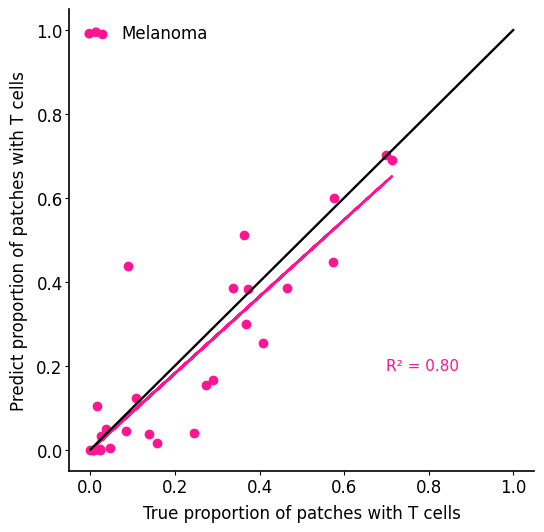

KeyError: 'CRC'

In [14]:
all_pred = {}
all_rmse = {}
for name, data in {
    "Melanoma": mla_data,
    # "CRC": crc_data,
    # "Breast tumor": bst_data,
}.items():
    thresh, _ = optimize_threshold(data, split="validate")
    pred, rmse = get_rmse_and_prediction(data, split="test", classify_threshold=thresh)
    print(f"{name} RMSE: {rmse}")
    print(f"{name} Threshold: {thresh}")
    all_pred[name] = pred
    all_rmse[name] = rmse

plot_prediction_scatterplot(all_pred)
plot_rmse(all_rmse)

### 1. Visualizing patient-level perturbations

In [ ]:
# import relevant functions
from analysis_helper import retrieve_perturbation
from figure_helper import plot_patient_perturbation

##### Melanoma

In [ ]:
patient_cf_mla[channel_to_perturb_mla].median(axis=0)

In [ ]:
cf_mla, channel_to_perturb_mla = retrieve_perturbation(
    mla_data, additional_col=["Cancer_Stage"]
)
strategy_mla, patient_cf_mla = plot_patient_perturbation(
    mla_data,
    cf_mla,
    channel_to_perturb_mla,
    numClust=3,
    extra_cols=["Cancer_Stage"],
)
strategy_mla = strategy_mla.iloc[:]  # keep the two major clusters
display(strategy_mla)

##### CRC

In [ ]:
cf_crc, channel_to_perturb_crc = retrieve_perturbation(
    crc_data, additional_col=["type", "FLD"]
)
strategy_crc, patient_cf_crc = plot_patient_perturbation(
    crc_data, cf_crc, channel_to_perturb_crc, numClust=2, extra_cols=["FLD"]
)
display(strategy_crc)

### 2. Assess effectiveness of perturbation on test cohort

In [ ]:
# import relevant functions
from analysis_helper import assess_perturbation
from figure_helper import plot_perturbation_performance

##### Melanoma

In [ ]:
tcell_level_melanoma = assess_perturbation(
    mla_data,
    strategy_mla,
    data_split="test",
    classify_threshold=0.31,
    additional_col=["Cancer_Stage"],
)
plot_perturbation_performance(
    tcell_level_melanoma,
    patient_phenotype="Cancer_Stage",
    strategy_mapping={
        "strategy_1": "IV",
        "strategy_2": "III",
    },  # mapping of the strategies to the phenotypes
)

##### CRC

In [ ]:
tcell_level_crc = assess_perturbation(
    crc_data,
    strategy_crc,
    data_split="test",
    classify_threshold=0.33,
    additional_col=["FLD", "type"],
)

tcell_level_crc["FLD"] = tcell_level_crc.apply(
    lambda x: 1 if x["FLD"] > 0 else 0, axis=1
)
tcell_level_patient = plot_perturbation_performance(
    tcell_level_crc,
    patient_phenotype="FLD",
    strategy_mapping={"strategy_1": 1, "strategy_2": 0},
)

### 3. Visualizing perturbation vectors in UMAP space

In [ ]:
from analysis_helper import get_umap_embeddings
from figure_helper import plot_umap_embedding, plot_umap_embedding_crc

In [ ]:
embedding_mla, umap_cf_mla = get_umap_embeddings(
    mla_data, cf_mla, channel_to_perturb_mla
)
plot_umap_embedding(embedding_mla, umap_cf_mla)

In [ ]:
plot_umap_embedding(embedding_mla, umap_cf_mla, pie_chart=True, save_fig=True)

In [ ]:
embedding_crc, umap_cf_crc = get_umap_embeddings(
    crc_data, cf_crc, channel_to_perturb_crc, additional_col=["type"]
)
plot_umap_embedding_crc(embedding_crc, umap_cf_crc)

### 4. Comparing patients across clusters with volcano plots

In [ ]:
from analysis_helper import differential_analysis_celltype, differential_analysis_genes
from figure_helper import make_volcano_plot

In [ ]:
mla_celltype_da = differential_analysis_celltype(mla_data, patient_cf_mla)
mla_genes_da = differential_analysis_genes(
    mla_data, patient_cf_mla, channel_to_perturb_mla
)
make_volcano_plot(mla_genes_da, mla_celltype_da)

In [ ]:
crc_celltype_da = differential_analysis_celltype(crc_data, patient_cf_crc)
crc_genes_da = differential_analysis_genes(
    crc_data, patient_cf_crc, channel_to_perturb_crc
)
make_volcano_plot(crc_genes_da, crc_celltype_da)

### 5. Tissue-level perturbation heatmap (CRC only)

In [ ]:
from figure_helper import plot_tissue_level_perturbation

In [ ]:
plot_tissue_level_perturbation(cf_crc, channel_to_perturb_crc)

### 6. Patch-level perturbation heatmap (Melanoma only)

In [ ]:
from analysis_helper import get_IHC_subset
from figure_helper import make_patch_heatmap_mla

In [ ]:
X, label = get_IHC_subset(mla_data, channel_to_perturb_mla)
make_patch_heatmap_mla(X, label, save_fig=True)

### 7. strategy at different sparsity

In [ ]:
from figure_helper import make_multi_strat_plot
import pandas as pd

In [ ]:
allStrategy = pd.DataFrame(
    [
        [0, 0, 0, 0, 0, 0, -100, 0, 0, 0.0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, -100, -100, 0, 0.0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, -100, -100, -50, 0.0, 0, 0, 0, 0, 0],
        [0, 0, -100, 0, 0, 0, -100, -100, -52, 0.0, 0, 0, 0, 0, 0],
    ],
    columns=channel_to_perturb_crc,
)
tcell_level_crc = assess_perturbation(
    crc_data,
    allStrategy,
    data_split="test",
    classify_threshold=0.33,
    additional_col=["FLD", "type"],
)

In [ ]:
make_multi_strat_plot(
    allStrategy, tcell_level_crc, chemlabel=["CXCR4", "PD1", "CYR61", "PDL1"]
)